# 1. 텍스트 데이터 다루기
> 신경망의 학습을 위해 텍스트를 수치형 텐서로 변환하는 과정(__텍스트 벡터화__)가 필요하다.

### 텍스트 벡터화 방식
* 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환
* 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환
* 텍스트에서 단어난 문자의 n-그램을 추출, 각 n-그램을 하나의 벡터로 변환한다. n-그램은 연속된 단어 & 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출

> 토큰 : 텍스트를 나누는 단위(단어, 문자)
> 토큰화 : 텍스트를 토큰으로 나누는 작업

## 토큰과 벡터를 연결하는 방법
#### 1. 원-핫 인코딩
> 모든 단어에 정수 인덱스 부여후 정수 인덱스 i를 크기가 어휘 사전의 크기인 이진 벡터로 변환한다.(원소 하나만 1이고 나머지 0)
#### 2. 토큰 임베딩(단어 임베딩)
> 실수형 밀집 벡터로 워-핫 인코딩에 비해 차원이 적다.
    
> 단어 임베딩을 만드는  방법   
   * 관심 대상인 문제와 함께 단어 임베딩 학습. 이런 경우 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습.
   * 풀려는 문제가 아닌 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드. 이를 __사전 훈련된 단어 임베딩__ 이라고한다.
   
> Embedding 층으로 단어 임베딩을 만들때 임베딩 공간에서 비슷한 뜻의 단어는 가까이 다른 뜻의 단어는 먼 곳에 배치한다

In [5]:
# Embedding 층의 객체 생성하기
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64) # Embedding 층은 적어도 2개의 매개변수를 받는다
# 가능한 토큰의 개수(1000으로 단언 인덱스 최대값 + 1와 임베딩차원(64)이다.

In [6]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 20  # 사용할 텍스트의 길이

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)  # 정수 리스트로 데이터 로드

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [7]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))  
# 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding 층에 input_length를 지정
# Embedding 층의 출력 크기는 (samples, maxlen, 8) 이 된다

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 5s 4ms/step - loss: 0.6855 - acc: 0.5695 - val_loss: 0.6168 - val_acc: 0.7004
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5698 - acc: 0.7415 - val_loss: 0.5236 - val_acc: 0.7334
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4728 - acc: 0.7819 - val_loss: 0.5006 - 

### 사전 훈련된 단어 임베딩 사용하기
케라스 임베딩 층을 위해 미리 계산된 단어 임베딩 DB의 일부로 __Word2vec, GloVe__ 이다.

### 모든 내용을 적용하기 : 원본 텍스트에서 단어 임베딩까지
> IMDB 데이터셋을 받고 압축 해제후 훈련 데이터 리스트와 리뷰 레이블 리스트를 만듦

In [25]:
import os 

imdb_dir ='./datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos'] :
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name) :
        if fname[-4:] == '.txt' :
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg' :
                labels.append(0)
            else :
                labels.append(1)

In [26]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 이후 단어는 버림
training_samples = 200   # 훈련 샘플은 200개
validation_samples = 10000   # 검증 샘플은 1만개 
max_words = 10000    # 데이터셋에서 빈도 높은 1만개 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유 토큰을 발견' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기: ', data.shape)
print('레이블 텐서의 크기: ', labels.shape)

indices = np.arange(data.shape[0])
# 데이터를 분활하기 전 샘플을 섞는다.
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

72633개의 고유 토큰을 발견
데이터 텐서의 크기:  (17243, 100)
레이블 텐서의 크기:  (17243,)


In [27]:
# GioVe 단어 임베딩 파일 파싱하기
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았다.


Embedding 층에 주입할 수 있게 임베딩 행렬을 만든다
> 행렬의 크기는 (max_words, embeddingdim)이다

* 행렬의 i번째 원소는 단어 인덱스 i번째 단어에 상응하는 임베딩 딤 차원 벡터이다.

### GloVe 단어 임베딩 행렬 준비하기

In [28]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # 임베딩 인덱스에 없는 단어는 0
            
# 모델 정의
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 모델에 GIoVe 임베딩 로드하기
Embedding 층은 하나의 가중치 행렬을 가진다(2D 부동 소수 행렬로 i번째 원소는 i번째 인덱스에 상으하는 단어 벡터)

In [29]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False  # Embedding 층 동결

In [30]:
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 6s 548ms/step - loss: 1.5896 - acc: 0.5681 - val_loss: 0.5885 - val_acc: 0.7278
Epoch 2/10
7/7 [==============================] - 3s 545ms/step - loss: 0.4343 - acc: 0.7667 - val_loss: 0.6001 - val_acc: 0.7278
Epoch 3/10
7/7 [==============================] - 3s 543ms/step - loss: 0.4243 - acc: 0.7745 - val_loss: 0.5903 - val_acc: 0.7288
Epoch 4/10
7/7 [==============================] - 2s 370ms/step - loss: 0.3238 - acc: 0.8379 - val_loss: 0.8434 - val_acc: 0.7278
Epoch 5/10
7/7 [==============================] - 3s 540ms/step - loss: 0.3188 - acc: 0.8211 - val_loss: 0.8054 - val_acc: 0.7278
Epoch 6/10
7/7 [==============================] - 3s 522ms/step - loss: 0.2432 - acc: 0.8416 - val_loss: 0.6535 - val_acc: 0.7277
Epoch 7/10
7/7 [==============================] - 3s 499ms/step - loss: 0.2052 - acc: 0.9346 - val_loss: 0.7865 - val_acc: 0.7278
Epoch 8/10
7/7 [==============================] - 3s 469ms/step - loss: 0.2197 - acc: 0.91

* 그래프를 보자!

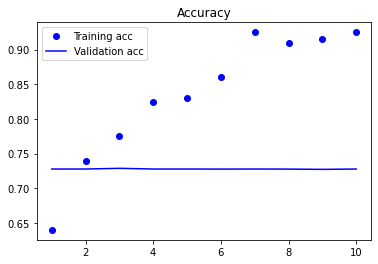

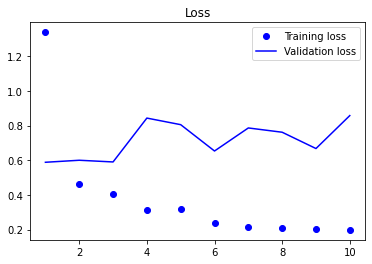

In [32]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss= history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.show()

#### 1. 적은 데이터라 과대 적합이 빠르게 일어난다
#### 2. 샘플 수가 적어서 고른 데이터에 따라 성능이 달라짐

### 정리
* 신경망에서 텍스트는 신경망이 처리할 수있는 형태로 변환하고 __케라스 모델에 Embedding 층을 추가__ 해 특정 작업에 특화된 토큰 임베딩을 학습한다.
* 데이터가 부족한 자연어 처리 문제에서 __사전 훈련된 단어 임베딩을 사용__ 하여 성능 향상이 가능하다.